# **1. Image Segmentation**

* 컴퓨터 비전 분야에서 이미지나 비디오의 디지털 데이터를 여러 개의 부분 또는 객체로 분할하는 기술
* 이미지의 중요한 요소들을 식별하고 각 요소를 개별적으로 분석 할 수 있게 하는 것

# **2. Image Segmentation의 유형**

* Semantic Segmentation
    * 이미지의 각 픽셀을 미리 정의된 클래스 레이블 중 하나로 분류
    * 예) 도로, 차선, 보행자 등을 식별

* Instance Segmentation
    * 동일한 클래스 내의 서로 다른 개체들을 개별적으로 식별
    * 예) 이미지 내의 개별 물체 수를 파악하고 각각 물체를 식별 및 추적하는 경우

* Panoptic Segmentation
    * Semantic Segmentation, Instance Segmentation를 결합한 형태
    * 배경과 같은 클래스를 처리하는 Semantic Segmentation와 객체를 구분하는 Instance Segmentation를 모두 수행
    * 예) 풍경 이미지에서 하늘, 도로, 나무와, 사람, 자동차를 동시에 식별

# **3.차량 파손 검사**

In [1]:
import os
import zipfile
import random
import shutil
import cv2
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
zip_path = '/content/drive/MyDrive/Korea it 아카데미/Project/Data/New_Sample.zip'
extract_path = '/content/drive/MyDrive/Korea it 아카데미/Project/Data/4'

In [3]:
# with zipfile.ZipFile(zip_path, 'r') as zip_ref :
#     zip_ref.extractall(extract_path)

In [4]:
data_root = '/content/drive/MyDrive/Korea it 아카데미/Project/Data/4'
file_root = f'{data_root}'
cls_list = ['Scratched', 'Separated', 'Crushed', 'Breakage']
project_name = 'cd'

In [5]:
train_root = f'{data_root}/{project_name}/train'
val_root = f'{data_root}/{project_name}/val'
test_root = f'{data_root}/{project_name}/test'

In [6]:
for folder in [train_root, val_root, test_root] :

    if not os.path.exists(folder) :
        os.makedirs(folder)

    for cls in ['images', 'labels'] :
        cls_folder = f'{folder}/{cls}'

        if not os.path.exists(cls_folder) :
            os.makedirs(cls_folder)

In [7]:
def json_to_yolo_polygon(polygon, w, h) :
    yolo_list = []

    for p in polygon :
        yolo_list.append(p[0] / w)
        yolo_list.append(p[1] / h)

    return ' '.join([str(x) for x in yolo_list])

In [8]:
file_list = glob.glob(f'{data_root}/라벨링데이터/TL_damage/damage/*.json')
random.seed(2024)
random.shuffle(file_list)

print(len(file_list))

1200


In [9]:
mask_name = file_list[0].split('/')[-1].replace('json', 'txt')
result = []

with open(file_list[0], 'r') as json_file :
    data = json.load(json_file)
    h = data['images']['height']
    w = data['images']['width']

    for ann in data['annotations'] :
        label = ann['damage']

        if label in cls_list :
            polygon_coord = ann['segmentation'][0][0][: -1]
            cood_string = json_to_yolo_polygon(polygon_coord, w, h)
            yolo_string = f'{cls_list.index(label)} {cood_string}'
            result.append(yolo_string)

In [10]:
result

['0 0.76875 0.3767572633552015 0.76 0.4029990627928772 0.71625 0.45454545454545453 0.6975 0.48828491096532334 0.60375 0.5473289597000938 0.41375 0.6597938144329897 0.36875 0.6597938144329897 0.5225 0.569821930646673 0.665 0.5051546391752577 0.705 0.4639175257731959 0.7375 0.4189315838800375 0.62875 0.4676663542642924 0.525 0.507029053420806 0.42125 0.5501405810684161 0.4175 0.5107778819119025 0.56125 0.45173383317713217 0.6975 0.3908153701968135']

In [11]:
# 라벨링 형태 변환 파일 생성(json -> txt)

if not os.path.isdir(f'{data_root}/labels') :
    os.mkdir(f'{data_root}/labels')

for file in tqdm(file_list) :
    result = []

    with open(file_list[0], 'r') as json_file :
        data = json.load(json_file)
        h = data['images']['height']
        w = data['images']['width']

        for ann in data['annotations'] :
            label = ann['damage']

            if label in cls_list :
                polygon_coord = ann['segmentation'][0][0][: -1]
                cood_string = json_to_yolo_polygon(polygon_coord, w, h)
                yolo_string = f'{cls_list.index(label)} {cood_string}'
                result.append(yolo_string)

    if result :
        save_path = file.replace('라벨링데이터/TL_damage/damage', 'labels').replace('json', 'txt')

        with open(save_path, 'w', encoding = 'utf-8') as f :
            f.write('\n'.join(result))

100%|██████████| 1200/1200 [11:57<00:00,  1.67it/s]


In [12]:
print(len(os.listdir(f'{data_root}/labels')))

1200


In [13]:
file_list = glob.glob(f'{data_root}/labels/*.txt')
random.shuffle(file_list)
test_ratio = 0.1
num_file = len(file_list)

test_list= file_list[: int(num_file * test_ratio)]
val_list= file_list[int(num_file * test_ratio) : int(num_file * test_ratio) * 2]
train_list= file_list[int(num_file * test_ratio) * 2 :]

In [14]:
for i in test_list:
    label_name = i.split('/')[-1]

    shutil.copyfile(i, f'{test_root}/labels/{label_name}')

    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'{data_root}/원천데이터/TS_damage/damage/{img_name}'
    shutil.copyfile(img_path, f'{test_root}/images/{img_name}')

for i in val_list:
    label_name = i.split('/')[-1]

    shutil.copyfile(i, f'{val_root}/labels/{label_name}')

    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'{data_root}/원천데이터/TS_damage/damage/{img_name}'
    shutil.copyfile(img_path, f'{val_root}/images/{img_name}')

for i in train_list:
    label_name = i.split('/')[-1]

    shutil.copyfile(i, f'{train_root}/labels/{label_name}')

    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'{data_root}/원천데이터/TS_damage/damage/{img_name}'
    shutil.copyfile(img_path, f'{train_root}/images/{img_name}')




In [15]:
%cd '/content/drive/MyDrive/Korea it 아카데미/Project/Data/4'

/content/drive/MyDrive/Korea it 아카데미/Project/Data/4


In [16]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 47.7 MB/s eta 0:00:00


In [17]:
import yaml
import ultralytics
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [18]:
# yaml 파일 만들기

data = dict()

data['train'] = train_root
data['val'] = val_root
data['test'] = test_root
data['nc'] = len(cls_list)
data['names'] = cls_list

with open(f'{data_root}/cd.yaml', 'w') as f :
    yaml.dump(data, f)

In [27]:
# YOLO 객체 만들기
# yolov8s-seg.yaml : 모델의 구조와 설정을 정의하는파일, 처음부터학습
# yolov8s-seg.pt : 학습된 모델을 사용하여 바로 세그머테이션 작업

# model = YOLO('yolov8n-seg.yaml')
model = YOLO('yolov8n-seg.pt')

results = model.train(data = 'cd.yaml', epochs = 5, batch = 16, imgsz = 224, device = 0,
                      workers = 4, amp = False, patience = 30, name = 'cd_n')

Ultralytics 8.3.0 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=cd.yaml, epochs=5, time=None, patience=30, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=cd_n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=No

train: Scanning /content/drive/MyDrive/Korea it 아카데미/Project/Data/4/cd/train/labels.cache... 1189 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1189/1189 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Korea it 아카데미/Project/Data/4/cd/val/labels.cache... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<?, ?it/s]


Plotting labels to runs/segment/cd_n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 72 weight(decay=0.0), 83 weight(decay=0.0005), 82 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/segment/cd_n
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5     0.791G      2.855      4.536      4.089      2.134         18        224: 100%|██████████| 75/75 [00:38<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.96it/s]

                   all        326        526    0.00795      0.257     0.0319    0.00674          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      0.78G      2.355      4.036      2.625      1.549          6        224: 100%|██████████| 75/75 [00:37<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


                   all        326        526      0.583      0.205     0.0496     0.0162   1.84e-05    0.00117   9.27e-06   9.27e-07

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5     0.784G      2.049      3.953      2.281      1.485         13        224: 100%|██████████| 75/75 [00:34<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.10it/s]

                   all        326        526      0.658      0.161      0.096     0.0314          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5     0.774G      1.895      3.871      2.165      1.429         15        224: 100%|██████████| 75/75 [00:35<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.11it/s]


                   all        326        526      0.573      0.129     0.0437     0.0227          0          0          0          0

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5     0.782G      1.794      3.781      2.103      1.407          9        224: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


                   all        326        526      0.676      0.234      0.109     0.0443          0          0          0          0

5 epochs completed in 0.073 hours.
Optimizer stripped from runs/segment/cd_n/weights/last.pt, 6.1MB
Optimizer stripped from runs/segment/cd_n/weights/best.pt, 6.1MB

Validating runs/segment/cd_n/weights/best.pt...
Ultralytics 8.3.0 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 213 layers, 2,937,564 parameters, 0 gradients, 10.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


                   all        326        526      0.676      0.234      0.109     0.0442          0          0          0          0
             Scratched        326        426      0.352      0.467      0.218     0.0884          0          0          0          0
             Separated        100        100          1          0          0          0          0          0          0          0
Speed: 0.0ms preprocess, 1.3ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/segment/cd_n


In [28]:
# 학습시키기

model = YOLO('yolov8s-seg.pt')

results = model.train(data = 'cd.yaml', epochs = 5, batch = 16, imgsz = 224, device = 0,
                      workers = 4, amp = False, patience = 30, name = 'cd_s')

100%|██████████| 22.8M/22.8M [00:00<00:00, 51.4MB/s]


Ultralytics 8.3.0 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.pt, data=cd.yaml, epochs=5, time=None, patience=30, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=cd_s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=No

train: Scanning /content/drive/MyDrive/Korea it 아카데미/Project/Data/4/cd/train/labels.cache... 1189 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1189/1189 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Korea it 아카데미/Project/Data/4/cd/val/labels.cache... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<?, ?it/s]


Plotting labels to runs/segment/cd_s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 72 weight(decay=0.0), 83 weight(decay=0.0005), 82 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/segment/cd_s
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      1.69G      2.701      4.472      3.683      2.075         18        224: 100%|██████████| 75/75 [00:42<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  2.00it/s]

                   all        326        526    0.00559      0.249     0.0118    0.00281   2.64e-05    0.00117   1.35e-05   1.35e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.66G      2.155      4.043      2.393      1.654          6        224: 100%|██████████| 75/75 [00:37<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:09<00:00,  1.14it/s]


                   all        326        526      0.592      0.144     0.0458     0.0117          0          0          0          0

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.65G      1.969       3.96      2.226      1.564         13        224: 100%|██████████| 75/75 [00:38<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.84it/s]


                   all        326        526      0.551      0.228     0.0291      0.012          0          0          0          0

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.64G      1.821      3.866       2.12      1.513         15        224: 100%|██████████| 75/75 [00:38<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.99it/s]

                   all        326        526      0.727      0.136       0.12     0.0439          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.65G      1.701      3.737      2.028      1.455          9        224: 100%|██████████| 75/75 [00:37<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.48it/s]

                   all        326        526      0.658      0.197     0.0921     0.0627          0          0          0          0



5 epochs completed in 0.074 hours.
Optimizer stripped from runs/segment/cd_s/weights/last.pt, 21.2MB
Optimizer stripped from runs/segment/cd_s/weights/best.pt, 21.2MB

Validating runs/segment/cd_s/weights/best.pt...
Ultralytics 8.3.0 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 213 layers, 10,483,228 parameters, 0 gradients, 37.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.91it/s]


                   all        326        526      0.658      0.197      0.092     0.0626          0          0          0          0
             Scratched        326        426      0.316      0.394      0.184      0.125          0          0          0          0
             Separated        100        100          1          0          0          0          0          0          0          0
Speed: 0.0ms preprocess, 2.2ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/segment/cd_s


In [29]:
model = YOLO('yolov8m-seg.pt')

results = model.train(data = 'cd.yaml', epochs = 5, batch = 16, imgsz = 224, device = 0,
                      workers = 4, amp = False, patience = 30, name = 'cd_m')

100%|██████████| 52.4M/52.4M [00:00<00:00, 160MB/s]


Ultralytics 8.3.0 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=cd.yaml, epochs=5, time=None, patience=30, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=cd_m, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=No

train: Scanning /content/drive/MyDrive/Korea it 아카데미/Project/Data/4/cd/train/labels.cache... 1189 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1189/1189 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Korea it 아카데미/Project/Data/4/cd/val/labels.cache... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<?, ?it/s]


Plotting labels to runs/segment/cd_m/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 92 weight(decay=0.0), 103 weight(decay=0.0005), 102 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/segment/cd_m
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      3.03G      2.623       4.38      3.367      2.047         18        224: 100%|██████████| 75/75 [00:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.22it/s]

                   all        326        526    0.00722      0.255     0.0352     0.0106          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.08G      2.127      4.033      2.386      1.712          6        224: 100%|██████████| 75/75 [00:39<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.85it/s]


                   all        326        526      0.519      0.112     0.0128    0.00562   6.47e-05    0.00469   3.26e-05   1.79e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.06G      1.931      3.951      2.216       1.63         13        224: 100%|██████████| 75/75 [00:39<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.81it/s]

                   all        326        526      0.532      0.113     0.0181     0.0078          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.04G      1.856      3.868      2.127      1.591         15        224: 100%|██████████| 75/75 [00:37<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.23it/s]


                   all        326        526      0.656      0.191      0.102     0.0441          0          0          0          0

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.08G      1.709      3.725      1.991      1.515          9        224: 100%|██████████| 75/75 [00:40<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:05<00:00,  1.98it/s]

                   all        326        526      0.609      0.244     0.0704      0.043          0          0          0          0



5 epochs completed in 0.077 hours.
Optimizer stripped from runs/segment/cd_m/weights/last.pt, 49.5MB
Optimizer stripped from runs/segment/cd_m/weights/best.pt, 49.5MB

Validating runs/segment/cd_m/weights/best.pt...
Ultralytics 8.3.0 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-seg summary (fused): 263 layers, 24,587,772 parameters, 0 gradients, 98.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:08<00:00,  1.31it/s]


                   all        326        526      0.657       0.19      0.103     0.0442          0          0          0          0
             Scratched        326        426      0.314       0.38      0.205     0.0884          0          0          0          0
             Separated        100        100          1          0          0          0          0          0          0          0
Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/cd_m


In [30]:
# best.pt로 yolo 객체 만들기

result_folder = f'{data_root}/runs/segment/'

In [31]:
model = YOLO(f'{result_folder}/cd_n/weights/best.pt')

In [32]:
model2 = YOLO(f'{result_folder}/cd_s/weights/best.pt')

In [33]:
model3 = YOLO(f'{result_folder}/cd_m/weights/best.pt')

In [34]:
# test 데이터로 val 하기

metrics = model.val(split = 'test')

Ultralytics 8.3.0 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 213 layers, 2,937,564 parameters, 0 gradients, 10.7 GFLOPs


val: Scanning /content/drive/MyDrive/Korea it 아카데미/Project/Data/4/cd/test/labels... 329 images, 0 backgrounds, 0 corrupt: 100%|██████████| 329/329 [02:21<00:00,  2.33it/s]


val: New cache created: /content/drive/MyDrive/Korea it 아카데미/Project/Data/4/cd/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:12<00:00,  1.63it/s]


                   all        329        529      0.686      0.235      0.113     0.0449          0          0          0          0
             Scratched        329        429      0.372      0.471      0.227     0.0899          0          0          0          0
             Separated        100        100          1          0          0          0          0          0          0          0
Speed: 0.1ms preprocess, 4.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/segment/val


In [58]:
# test 데이터 모두 불러와 셔플하기
test_file_list = glob.glob(f'{test_root}/images/*')
random.shuffle(test_file_list)


0: 224x192 (no detections), 9.4ms
Speed: 1.1ms preprocess, 9.4ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 192)


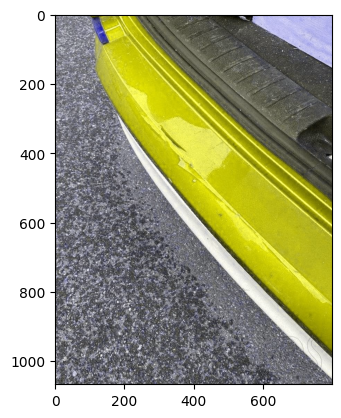

In [60]:
# 그 중 첫번째 파일 모델에 넣고 예측하기

test_img = cv2.imread(test_file_list[0])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)[0]

plt.imshow(test_img)
plt.show()

In [61]:
from skimage.draw import polygon2mask

<function matplotlib.pyplot.show(close=None, block=None)>

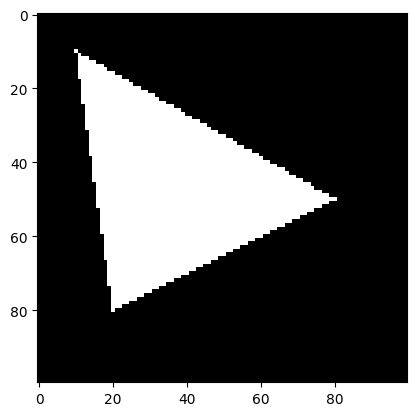

In [62]:
# polygon2mask : 이미지에서 다각형 형태의 영역을 마스크로 변환하는 함수
# 주로 이미지 처리와 컴퓨터 비전 작업에서 사용

image_shape = (100, 100)
polygon = np.array([[10, 10], [80, 20], [50, 80]])
mask = polygon2mask(image_shape, polygon)

plt.imshow(mask, cmap = 'gray')
plt.show


0: 192x224 1 Scratched, 18.1ms
Speed: 1.2ms preprocess, 18.1ms inference, 13.8ms postprocess per image at shape (1, 3, 192, 224)


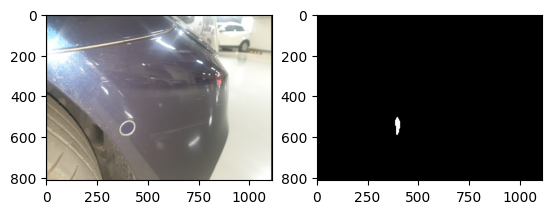

In [85]:
test_img = cv2.imread(test_file_list[22])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)[0]

result_mask = np.zeros(test_img.shape[: 2])
masks = result.masks

for m in masks :
    polygon_coor = m.xy[0]

    # 주어진 이미지 크기와 폴리곤 좌표를 사용하여 해당 영역을 1로 채운 마스크 생성
    # 나머지는 0으로 유지

    mask = polygon2mask(test_img.shape[: 2], polygon_coor)

    # maximum : 두배열의 요소별 최대값을 반환하므로 여러 객체의 마스크가 겹치더라도 최대값 유지

    result_mask = np.maximum(mask, result_mask)

    # 2D 마스크를 3D 배열로 변환하고 동일한 값을 3채널로 복사


result_mask = np.repeat(result_mask[:, :, np.newaxis], 3, -1)

plt.subplot(1, 2, 1)
plt.imshow(img_src)
plt.subplot(1, 2, 2)
plt.imshow(result_mask)

plt.show()